In [40]:
# Checkout www.pygimli.org for more examples
%matplotlib inline


3D modeling in a closed geometry
================================

This is a synthetic model of an experimental tank with a highly heterogeneous
resistivity, motivated by the BAM Berlin.

Geometry: 0.99m x 0.5m x 1.0m
Data: 48 Electrodes and 588 Measurements defined in modeltank.shm
Each 24 electrodes are located at two opposite sides of the tank.

We use the pygimli meshtools to create a PLC of the tank and an inhomogeneity.
The needed mesh is created by calling tetgen.


In [41]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.ert import simulate as simulateERT

In contrast to field measurements, experimental tanks have well-defined
spatial dimensions and need different boundary conditions (BC).

As there is no current flow through the tanks boundary at all, homogeneous
(Neumann) BC are defined for the whole boundary.
Neumann BC are natural (intrinsic) for the finite element simulations.
\link{tutorial:fem:bc}, so we just need to define a cube geometry including
region markers.



In [42]:
plc = mt.createCube(size=[0.99, 0.5, 1.0], pos=[0.495, 0.25], boundaryMarker=1)

We first read the measuring scheme file and add the electrodes as nodes with
the marker -99 to the geometry.



In [43]:
filename = pg.getExampleFile("ert/modeltank.shm")
shm = pg.DataContainerERT(filename)

for s in shm.sensors():
    plc.createNode(s, marker=-99)

There are two small problems to overcome for simulating Neumann bodies.

First, we always need dipole current injection since there can be no current
flow out of the closed boundaries of our experimental tank.
(Note that by default single poles are simulated and superpositioned.)
Therefore we define a reference electrode position inside the PLC, with a
marker -999, somewhere away from the electrodes.



In [44]:
plc.createNode([0.5, 0.5, -0.5], marker=-999)

The second problem for pure Neumann domains is the non-uniqueness of
the partial differential equation (there are only partial derivatives of the
electric potential so an arbitrary value might be added, i.e. calibrated).

Therefore we add calibration node with marker -1000 where the potential is
fixed , somewhere on the boundary and far from the electrodes.



In [45]:
plc.createNode([0.75, 0.25, 0.5], marker=-1000)

For sufficient numerical accuracy it is generally a good idea to refine the
mesh in the vicinity of the electrodes positions.
We force the local mesh refinement by an additional node at 1/2 mm
distance in -z-direction.



In [46]:
for s in plc.positions(pg.find(plc.nodeMarkers() == -99)):
    plc.createNode(s - [0.0, 0.0, 1e-3/2])

# Also refine the reference node
plc.createNode([0.5, 0.5, -0.5 - 1e-3/2])

Create the tetrahedron mesh (calling the tetgen mesh generator)



In [47]:
mesh = mt.createMesh(plc, area = 1)

First we want to simulate our ERT response for a homogeneous resistivity
of 1 $\Omega$m. Usually, simulate will calculate apparent resistivities
(rhoa) and put them into the returned DataContainerERT.
However, for the calculation of rhoa, geometric factors (k) are expected in
the data container.
If simulate does not find any k in the scheme file, it tries to determine
them itself, either analytically (halfspace) or numerically (topography).
Note that the automatic numerical calculating can only be a fallback mode.
You usually want to keep full control about this calculation because you want
the accuracy as high as possible by providing a special mesh with
higher quality, lower max cell area, finer local mesh refinement,
or quadratic base functions (p2).

We don't want the automatic k generation here because we want also to
demonstrate how you can solve this task yourself.
The argument 'calcOnly=True' omits the check for valid k factors
and will add the simulated voltages (u) in the returned DataContainerERT.
The simulation current (i) is 1 A by default. In addition, the flag
'sr=False' omits the singularity removal technique (default) which not
applicable in absence of (analytic) primary potential.



In [48]:
hom = simulateERT(mesh, res=1.0, scheme=shm, sr=False,
                  calcOnly=True, verbose=True)

hom.save('homogeneous.ohm', 'a b m n u')

1

We now create an inhomogeneity (cube) and merge it with the above PLC.
marker=2 ensures all cells of the cube being associated with a cell marker 2.



In [49]:
cube = mt.createCube(size=[0.3, 0.2, 0.8], pos=[0.7, 0.2], boundaryMarker=2)
plc += cube

mesh = mt.createMesh(plc,area = 1)
print(mesh)

Mesh: Nodes: 10671 Cells: 47936 Boundaries: 101145


Until we find a way (TODO) showing 3D structures in a 2D documentation,
it is advisable to control the geometry in a 3D viewer. We recommend Paraview
https://www.paraview.org/ and will export the geometry and in the
vtk file format.



In [50]:
# plc.exportVTK('plc')
# mesh.exportVTK('mesh')

Now that we have a mesh with different regions and cell markers, we can define
a relationship between region marker and resistivity by defining a appropriate
list. We also set sr=False here because singularity removal would need highly
accurate primary potentials which can also only be calculated numerically.



07/04/21 - 12:09:53 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 2 within mesh.


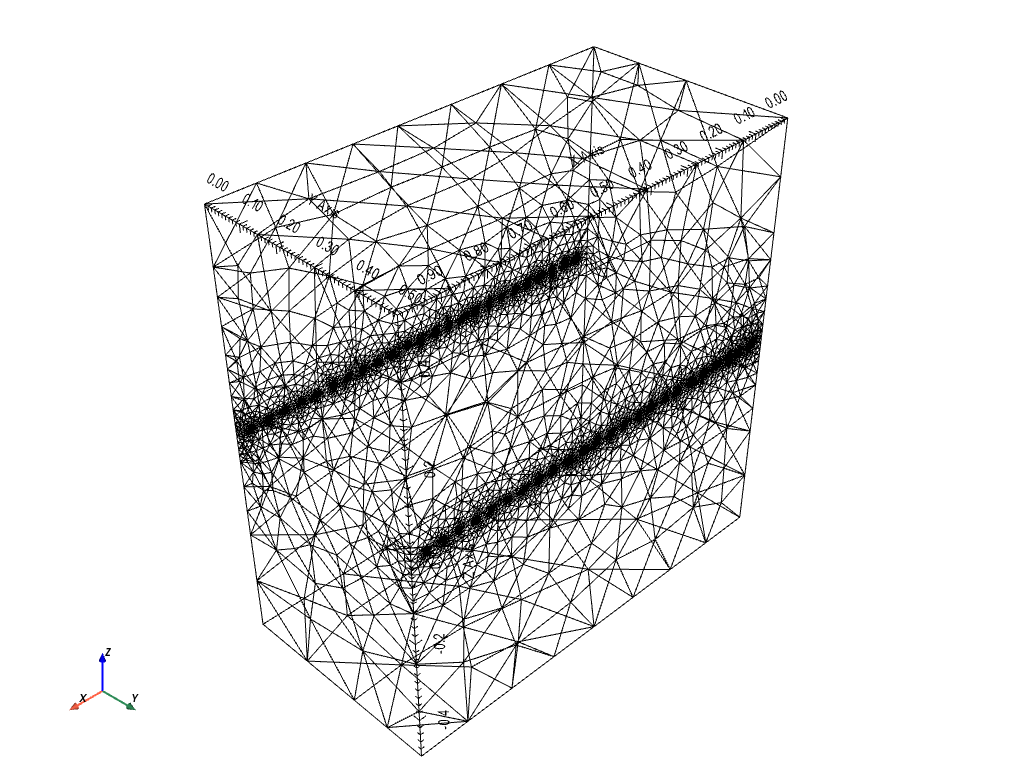

(<pyvista.plotting.plotting.Plotter at 0x7f9df4d46ed0>, None)

In [51]:
# res = [[1, 1.0], [2, 1.0]]
# hom = simulateERT(mesh, res=res, scheme=shm, sr=False,
#                   calcOnly=True, verbose=True)

res = [[1, 10.0], [2, 10.0]]  # map markers 1 and 2 to 10 and 100 Ohmm, resp.
het = simulateERT(mesh, res=res, scheme=shm, sr=False,
                  calcOnly=True, verbose=True)
pg.show(mesh, notebook=True)

The apparent resistivity for a homogeneous model of 1 Ohmm should be 1 Ohmm.
Therefore we can take the inverse of the modeled resistances for the
homogeneous model and use it as geometric factors to find the apparent
resistivities for the inhomogeneous model.



In [52]:
mesh.cellMarkers()

In [53]:
het.set('k', 1.0/ (hom('u') / hom('i')))
het.set('rhoa', het('k') * het('u') / het('i'))

het.save('simulated.dat', 'a b m n rhoa k u i')

np.testing.assert_approx_equal(het('rhoa')[0], 9.95, 2)

# np.testing.assert_approx_equal(het('k')[0], 0.820615269548)

# pg.wait()

In [54]:
np.min(het('rhoa').array())

8.956386691401086

For such kind of simulations, the homogeneous part should be high accurate
because it is usually needed once after storing the geometric factors.
Note, do not forget to add some noise if you plan to invert such simulated
data.

see also:

TODO
* inversion example

checks:
TODO:
* any idea for a Figure here?
* Alternatively, we can create a real cavity by changing the marker
in isHole flag for createCube (check)

